In [9]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats

In [2]:
import sys

sys.path.append("../src")

In [8]:
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
from core import SITE_NAMES

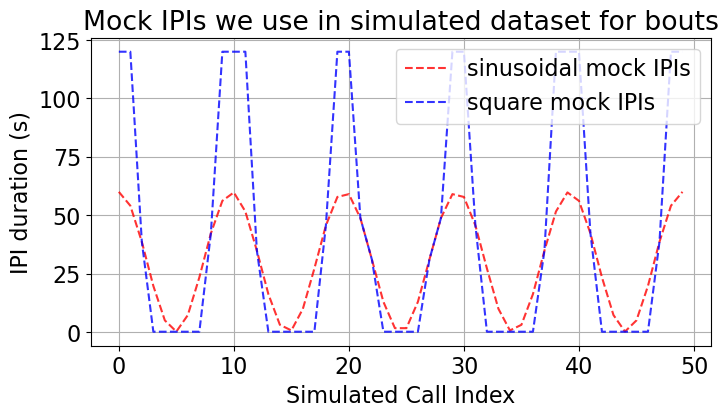

In [33]:
peak = 60
amplitude = (peak/2) - 0.05
b = (peak-amplitude)/amplitude
mock_sin_ipis = amplitude*(np.sin((np.linspace(0, 10*np.pi, 50)) + np.pi/2)+b)
mock_square_ipis = mock_sin_ipis.copy()
mock_square_ipis[mock_square_ipis>(amplitude+20)] = peak
mock_square_ipis[mock_square_ipis<peak-(30)] = amplitude*(-1 + b)
mock_square_ipis[mock_square_ipis==peak] = 120

plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size':16})
plt.title('Mock IPIs we use in simulated dataset for bouts')
plt.plot(mock_sin_ipis, color='red', alpha=0.8, linestyle='dashed', label='sinusoidal mock IPIs')
plt.plot(mock_square_ipis, color='blue', alpha=0.8, linestyle='dashed', label='square mock IPIs')
plt.grid(which='both')
# plt.ylim(-1, (amplitude*2)+5)
plt.ylabel('IPI duration (s)')
plt.xlabel('Simulated Call Index')
plt.legend(loc='upper right')
plt.show()

In [18]:
def create_initial_mock_data_from_ipis(ipis):
    mock_df = pd.DataFrame(columns=['ref_time', 'call_start_time', 'call_end_time', 'start_time', 'end_time', 'low_freq', 'high_freq', 'freq_group'])
    recording_start = dt.datetime(2022, 6, 15, 1, 00, 0)
    recording_end = recording_start+dt.timedelta(minutes=30)
    for i in range(0, len(ipis)):
        start_time = ipis[:i+1].cumsum(axis=0)[-1]
        call_start_time = recording_start + dt.timedelta(seconds=start_time)
        call_end_time = recording_start + dt.timedelta(seconds=start_time+0.01)
        ref_time = pd.to_datetime(call_start_time).floor('30T')
        if (call_end_time <= recording_end):
            mock_df.loc[i] = [ref_time, call_start_time, call_end_time, start_time, start_time+0.01, 20000, 30000, 'LF1']

    return mock_df

In [19]:
mock_bout_df = create_initial_mock_data_from_ipis(mock_square_ipis)
mock_bout_df = ss.simulate_dutycycle_on_detections(mock_bout_df, '1800of1800')

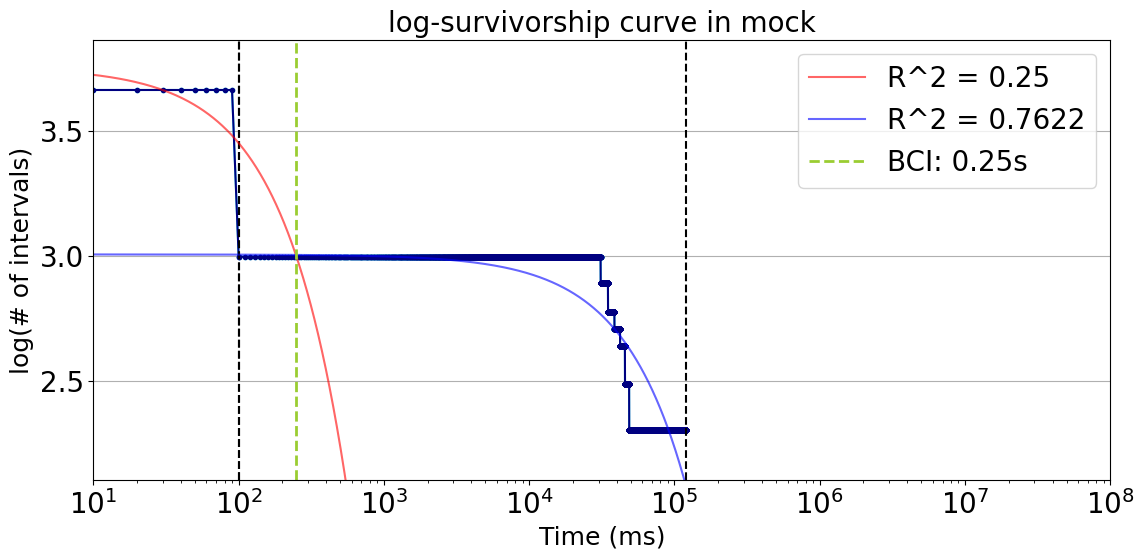

{'LF1_bci': 247.52456950656747}

In [20]:
fig_details = dict()
fig_details['site_name'] = 'mock'
fig_details['freq_group'] = ''
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000

bout_params = dict()

group = 'LF1'
freq_group_df = mock_bout_df.loc[mock_bout_df['freq_group']==group].copy()
ipis_loc, hist_loc = bt_clustering.get_histogram(freq_group_df, 10)
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)
values = hist_loc[0]
max_val = np.max(values)
first_peak = np.where(values==max_val)[0][0]
fast_inds = range(0, int(np.ceil(1.1*first_peak))+1)
fast_coeff = stats.linregress(intervals_ms[fast_inds], survival[fast_inds])

fast_process = dict()
fast_process['metrics'] = fast_coeff
fast_process['indices'] = fast_inds
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)
slow_inds = np.logical_and(survival >= (survival.max() * 0.2), survival <= (survival.max() * 0.85)) 
slow_coeff = stats.linregress(intervals_ms[slow_inds], survival[slow_inds])

slow_process = dict()
slow_process['metrics'] = slow_coeff
slow_process['indices'] = slow_inds
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)
bci, misassigned_points = bt_clustering.get_bci_from_slater_method(fast_process, slow_process)
bt_plt.plot_bci_over_survival(intervals_ms, survival, fast_process, slow_process, bci, fig_details)
bout_params[f'{group}_bci'] = bci
bout_params

In [21]:
batdetect2_predictions = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(mock_bout_df, bout_params)
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_predictions)
bout_metrics

,freq_group,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,number_of_dets,bout_duration,bout_duration_in_secs
0,LF1,2022-06-15 01:04:38.571601,2022-06-15 01:04:39.081601,278.571601,279.081601,278.571601,279.081601,20000,30000,6,0 days 00:00:00.510000,0.51
1,LF1,2022-06-15 01:11:56.074879,2022-06-15 01:11:56.584879,716.074879,716.584879,716.074879,716.584879,20000,30000,6,0 days 00:00:00.510000,0.51
2,LF1,2022-06-15 01:18:01.884201,2022-06-15 01:18:02.294201,1081.884201,1082.294201,1081.884201,1082.294201,20000,30000,5,0 days 00:00:00.410000,0.41
3,LF1,2022-06-15 01:24:07.593523,2022-06-15 01:24:08.103523,1447.593523,1448.103523,1447.593523,1448.103523,20000,30000,6,0 days 00:00:00.510000,0.51
